In [1]:
import time
import torch
import numpy as np
from train_eval import train, init_network
from importlib import import_module
import argparse
# from utils import build_dataset, build_iterator, get_time_dif


dataset = 'Newtrain_qinggan'  # 数据集

model_name = 'bert'  # bert
x = import_module('models.' + model_name)
config = x.Config(dataset)

In [2]:
import torch
from tqdm import tqdm
import time
import random
from datetime import timedelta

PAD, CLS = '[PAD]', '[CLS]'  # padding符号, bert中综合信息符号
class_list = ['价格', '配置', '操控', '舒适性', '油耗', '动力', '内饰', '安全性', '空间', '外观']

def build_dataset_bert(config):

    def load_dataset(path, pad_size=32):
        contents = []
        with open(path, 'r', encoding='UTF-8') as f:
            for line in tqdm(f):
                lin = line.strip()
                if not lin:
                    continue
                tmp_data = lin.split('\t')
                content = tmp_data[0].replace(" ", "")
                # content, label = lin.split('\t')
                token = config.tokenizer.tokenize(content)
                zhuti_label = [class_list.index(t.split('#')[0]) for t in tmp_data[1:]]

                cal_qinggan = sum([int(t.split('#')[1]) for t in tmp_data[1:]])
                qinggan_label = 1
                if cal_qinggan > 0:
                    qinggan_label = 2
                elif cal_qinggan < 0:
                    qinggan_label = 0

                token = [CLS] + token
                seq_len = len(token)
                mask = []
                token_ids = config.tokenizer.convert_tokens_to_ids(token)

                if pad_size:
                    if len(token) < pad_size:
                        mask = [1] * len(token_ids) + [0] * (pad_size - len(token))
                        token_ids += ([0] * (pad_size - len(token)))
                    else:
                        mask = [1] * pad_size
                        token_ids = token_ids[:pad_size]
                        seq_len = pad_size
                contents.append((token_ids, zhuti_label, int(qinggan_label), seq_len, mask))
                if 'test' not in path:
                    # 过采样
                    # if qinggan_label in [0, 2]:
                    #     for copyy in range(4):
                    #          contents.append((token_ids, zhuti_label, int(qinggan_label), seq_len, mask))
                    # 欠采样
                    if qinggan_label not in [0, 2]:
                        if random.random() > 0.2:
                            contents.pop()
        return contents
    train = load_dataset(config.train_path, config.pad_size)
    test = load_dataset(config.test_path, config.pad_size)
    random.shuffle(train)
    random.shuffle(test)
    return train, test


train, test = build_dataset_bert(config)
print(len(train), len(test))
from collections import defaultdict
c = defaultdict(int)
for i in train:
    c[i[2]] += 1
print(c)

8000it [00:01, 5337.52it/s]
2653it [00:00, 5590.24it/s]

3490 2653
defaultdict(<class 'int'>, {1: 1150, 0: 1196, 2: 1144})


In [3]:
import torch
import torch.nn.functional as F
from utils import build_iterator_bert
train_iter = build_iterator_bert(train, config)
test_iter = build_iterator_bert(test, config)

# print(train_iter.__next__()[0])
model = x.Model(config).to(config.device)


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time
from utils import get_time_dif
from pytorch_pretrained.optimization import BertAdam
import numpy as np
import torch
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time
from collections import defaultdict
from utils import get_time_dif
from tensorboardX import SummaryWriter

config.num_epochs = 50
config.batch_size = 32
config.require_improvement = 400
config.log_path = dataset + '/log/' + config.model_name
class FocalLoss(nn.Module):
    """
    参考 https://github.com/lonePatient/TorchBlocks
    """

    def __init__(self, gamma=2.0, alpha=1, epsilon=1.e-9, device=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha).to(config.device)
        else:
            self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, input, target):
        """
        Args:
            input: model's output, shape of [batch_size, num_cls]
            target: ground truth labels, shape of [batch_size]
        Returns:
            shape of [batch_size]
        """
        num_labels = input.size(-1)
        idx = target.view(-1, 1).long()
        one_hot_key = torch.zeros(idx.size(0), num_labels, dtype=torch.float32, device=idx.device)
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        one_hot_key[:, 0] = 0  # ignore 0 index.
        logits = torch.softmax(input, dim=-1)
        # print(one_hot_key)
        # print(sdf)
        loss = -self.alpha * one_hot_key * torch.pow((1 - logits), self.gamma) * (logits + self.epsilon).log()
        loss = loss.sum(1)
        return loss.mean()

def train_qinggan(config, model, train_iter, test_iter):
    start_time = time.time()
    model.train()
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=config.learning_rate,
                         warmup=0.05,
                         t_total=len(train_iter) * config.num_epochs)
    total_batch = 0  # 记录进行到多少batch
    dev_best_loss = float('inf')
    train_dict = defaultdict(list)
    test_dict = defaultdict(list)
    loss_fn = FocalLoss(alpha=[1, 1, 1], device = config.device)
    last_improve = 0  # 记录上次验证集loss下降的batch数
    flag = False  # 记录是否很久没有效果提升
    model.train()
    for epoch in range(config.num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, config.num_epochs))
        for i, (trains, qinggan_label, zhuti_label) in enumerate(train_iter):
            outputs = model(trains)
            model.zero_grad()
            # loss = F.cross_entropy(outputs, labels)
            qinggan_label = qinggan_label.to(config.device)
            # loss = FocalLoss(alpha=[8000 / 1196, 8000/5660, 8000/1144])
            # loss = loss_fn(outputs, qinggan_label)
            loss = F.cross_entropy(outputs, qinggan_label)
            loss.backward()
            optimizer.step()
            if total_batch % 10 == 0:
                # 每多少轮输出在训练集和验证集上的效果
                true = qinggan_label.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                train_acc = metrics.accuracy_score(true, predic)
                train_precision = metrics.precision_score(true, predic, average='macro', zero_division=0)
                train_recall = metrics.recall_score(true, predic, average='macro', zero_division=0)
                train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-5)
                # dev_acc, dev_loss = evaluate_qinggan(config, model, dev_iter)
                dev_acc, dev_loss, dev_p, dev_r, dev_f1 = evaluate_qinggan(config, model, test_iter)
                if dev_loss < dev_best_loss:
                    dev_best_loss = dev_loss
                    torch.save(model.state_dict(), config.save_path)
                    improve = '*improve'
                    last_improve = total_batch
                else:
                    improve = ''
                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.2},  Train Acc: {2:>6.2%},  Val Loss: {3:>5.2},  Val Acc: {4:>6.2%},  Time: {5} {6}'
                print(msg.format(total_batch, loss.item(), train_acc, dev_loss, dev_acc, time_dif, improve))
                train_dict['train_loss'].append(loss.item())   
                train_dict['train_acc'].append(train_acc)
                train_dict['train_precision'].append(train_precision)
                train_dict['train_recall'].append(train_recall)
                train_dict['train_f1'].append(train_f1)
                test_dict['dev_acc'].append(dev_acc)
                test_dict['dev_loss'].append(dev_loss.item())
                test_dict['dev_precision'].append(dev_p)
                test_dict['dev_recall'].append(dev_r)
                test_dict['dev_f1'].append(dev_f1)
                with open(config.log_path + '/train_dict.json', 'w') as json_file:
                    json.dump(train_dict, json_file, indent=4)  # indent参数使输出更加易读
                with open(config.log_path + '/test_dict.json', 'w') as json_file:
                    json.dump(test_dict, json_file, indent=4)  # indent参数使输出更加易读
                model.train()
            total_batch += 1
            if total_batch - last_improve > config.require_improvement:
                # 验证集loss超过1000batch没下降，结束训练
                print("No optimization for a long time, auto-stopping...")
                flag = True
                break
        if flag:
            break


def evaluate_qinggan(config, model, data_iter, test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    loss_fn = FocalLoss(alpha=[1, 1, 1],  device = config.device)
    with torch.no_grad():
        for texts, qinggan_label, zhuti_label in data_iter:
            outputs = model(texts)

            qinggan_label = qinggan_label.to(config.device)
            loss = F.cross_entropy(outputs, qinggan_label)
            # loss = loss_fn(outputs, qinggan_label)
            loss_total += loss
            labels = qinggan_label.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    p = metrics.precision_score(labels_all, predict_all, average='macro', zero_division=0)
    r = metrics.recall_score(labels_all, predict_all, average='macro', zero_division=0)
    f1 =  2 * (p * r) / (p + r + 1e-5)

    return acc, loss_total / len(data_iter), p, r, f1

train_qinggan(config, model, train_iter, test_iter)

Epoch [1/50]


/mnt/workspace/Bertchinese/pytorch_pretrained/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Iter:      0,  Train Loss:   1.3,  Train Acc: 28.91%,  Val Loss:   1.4,  Val Acc: 14.29%,  Time: 0:00:02 *improve
Iter:     10,  Train Loss:   1.1,  Train Acc: 46.88%,  Val Loss:   1.1,  Val Acc: 37.69%,  Time: 0:00:06 *improve
Iter:     20,  Train Loss:  0.94,  Train Acc: 57.03%,  Val Loss:   1.0,  Val Acc: 49.57%,  Time: 0:00:09 *improve
Epoch [2/50]
Iter:     30,  Train Loss:  0.91,  Train Acc: 55.47%,  Val Loss:  0.94,  Val Acc: 57.11%,  Time: 0:00:13 *improve
Iter:     40,  Train Loss:   1.1,  Train Acc: 46.09%,  Val Loss:  0.86,  Val Acc: 61.40%,  Time: 0:00:17 *improve
Iter:     50,  Train Loss:  0.78,  Train Acc: 67.19%,  Val Loss:   1.3,  Val Acc: 43.42%,  Time: 0:00:20 
Epoch [3/50]
Iter:     60,  Train Loss:  0.62,  Train Acc: 79.69%,  Val Loss:  0.88,  Val Acc: 64.12%,  Time: 0:00:23 
Iter:     70,  Train Loss:  0.72,  Train Acc: 66.41%,  Val Loss:   1.2,  Val Acc: 53.52%,  Time: 0:00:26 
Iter:     80,  Train Loss:  0.63,  Train Acc: 69.53%,  Val Loss:   1.1,  Val Acc: 49.0

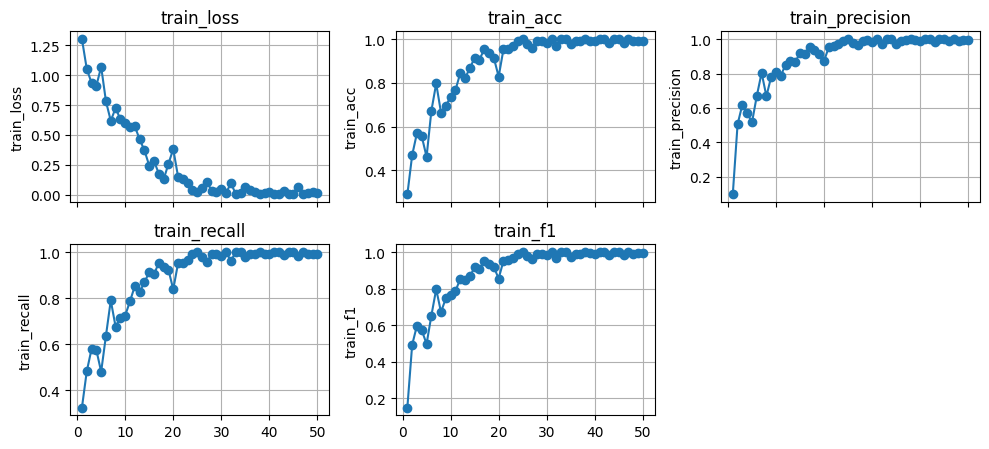

In [5]:
import json

with open(config.log_path + '/train_dict.json', 'r', encoding='utf-8') as file:
    train_dict = json.load(file)
with open(config.log_path + '/test_dict.json', 'r', encoding='utf-8') as file:
    test_dict = json.load(file)
import matplotlib.pyplot as plt

epochs = range(1, len(train_dict['train_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(train_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(train_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()

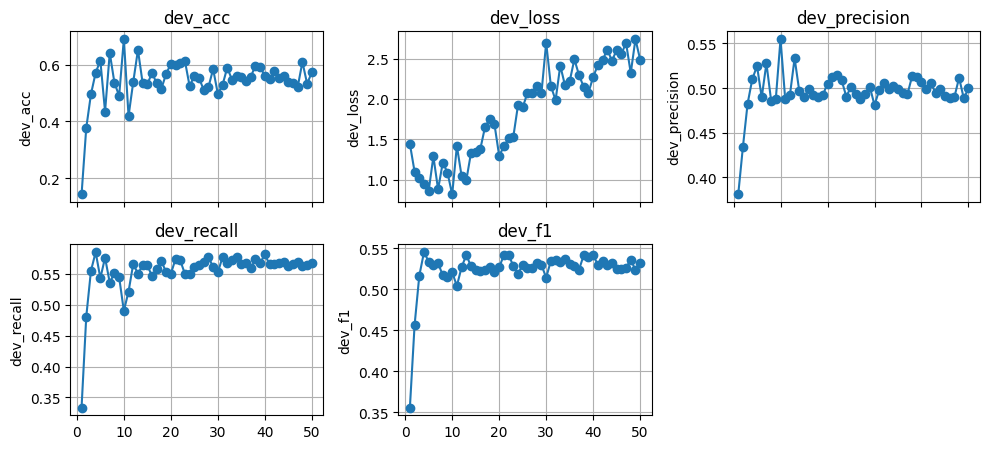

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_dict['dev_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(test_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(test_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()